In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_handler import DataHandler, ScatterDataHandler, BroadcastDataHandler, LatencyDataHandler
import os
from mpl_toolkits.mplot3d import Axes3D

## Data loading

In [18]:
dh_bcast = []
dh_scat = []
dh_latency = []
dh_latency_EPYC = []
    
for file in os.listdir('output_data/broadcast'):
    if file.endswith('.csv'):
        dh_bcast.append(BroadcastDataHandler(f'output_data/broadcast/{file}'))
for file in os.listdir('output_data/scatter'):
    if file.endswith('.csv'):
        dh_scat.append(DataHandler.from_file(f'output_data/scatter/{file}'))
for file in os.listdir('output_data/latency'):
    if file.endswith('.csv') and not file.endswith('EPYC.csv'):
        dh_latency.append(LatencyDataHandler(f'output_data/latency/{file}'))
for file in os.listdir('output_data/latency'):
    if file.endswith('EPYC.csv'):
        dh_latency_EPYC.append(LatencyDataHandler(f'output_data/latency/{file}'))

## Latency

In order to have a baseline model to compare with, we will use the `osu_latency` benchmark from the `osu-micro-benchmarks` suite. This benchmark measures the latency of a message exchange between two MPI processes. For this test we will use two different partitions: THIN and EPYC. This way we can compare the two architectures.

The tests are:
- **intra socket (EPYC)**:
  - `0:0`
  - ...
  - `0:127`
- **intra socket (THIN)**:
  - `0:0`
  - ...
  - `0:11`
- **intra node (THIN)**:
  - `00:10`
  - `00:13`
  - `00:16`
  - `00:1{10}`
- **intra cluster (THIN)**:
  - `000:100`
  - `000:110`
  - `010:100`

### EPYC vs THIN

Now we compare the latency of the two architectures.

In [19]:
lat_thin = [ dh for dh in dh_latency if dh.entity == 'socket' ]
# lat_epyc = [ dh for dh in dh_latency_EPYC if dh.entity == 'socket' ]

size = 8

y_thin = [ dh.time(size) for dh in lat_thin ]
# y_epyc = [ dh.time(size) for dh in lat_epyc ]

y_thin = np.array([ y for y in y_thin if y.size>0]).flatten()
# y_epyc = np.array([ y for y in y_epyc if y.size>0]).flatten()

In [20]:
y_thin_avg = np.mean(y_thin[1:])
print(f'Thin average: {y_thin_avg}')
y_thin_diff = y_thin - y_thin_avg
print(f'Thin diff: {y_thin_diff}')
y_thin_new = y_thin - y_thin_diff/1.5

Thin average: 0.19999999999999998
Thin diff: [ 1.23597500e+04 -1.00000000e-02 -2.00000000e-02  2.77555756e-17
 -1.00000000e-02  4.00000000e-02 -1.00000000e-02 -1.00000000e-02
 -1.00000000e-02 -1.00000000e-02  5.00000000e-02 -1.00000000e-02]


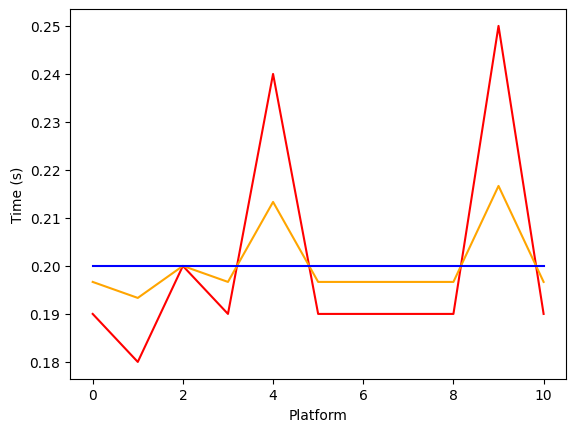

In [21]:
fig, ax = plt.subplots()
# ax.scatter(np.arange(y_thin.size-1), y_thin[1:], label='Thin', color='blue')
ax.plot(y_thin[1:], label='THIN', color='red')
ax.plot(y_thin_new[1:], label='THIN', color='orange')
ax.plot(np.arange(y_thin.size-1),np.ones(y_thin.size-1)*y_thin_avg, label='THIN avg', color='blue')
ax.set_ylabel('Time (s)')
ax.set_xlabel('Platform')
plt.show()

In [ ]:
y_thin_new[0] = y_thin[0]
print(f'Thin new: {y_thin_new}')

In [ ]:
np.std(y_thin_new[1:])/np.mean(y_thin_new[1:])

#### Latency between 0 and 1 all message sizes

In [ ]:
y_01 = np.array([ dh.data['Avg Latency (us)'] for dh in lat_thin[1:]])
x_01 = dh_latency[0].data.index.values

In [ ]:
x_01.shape

In [ ]:
y_avg = np.mean(y_01, axis=0)

### Intra socket

In [31]:
lat_thin = [ dh for dh in dh_latency if dh.entity == 'socket' ]
size = 8

y_thin = [ dh.time(size) for dh in lat_thin ]
y_thin = np.array([ y for y in y_thin if y.size>0]).flatten()

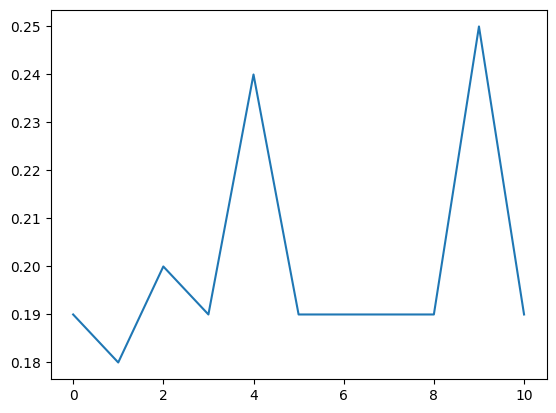

In [33]:
plt.plot(y_thin[1:])

### Intra Node

In [25]:
lat_thin = [ dh for dh in dh_latency if dh.entity == 'node' ]

size = 8

y_thin = [ dh.time(size) for dh in lat_thin ]

y_thin = np.array([ y for y in y_thin if y.size>0]).flatten()

In [23]:
print(f"Mean: {np.mean(y_thin):.4f}")
print(f"Std: {np.std(y_thin):.4f}")
print(f"Std/Mean: {np.std(y_thin)/np.mean(y_thin):.4f}")

Mean: 63.6575
Std: 0.8918
Std/Mean: 0.0140


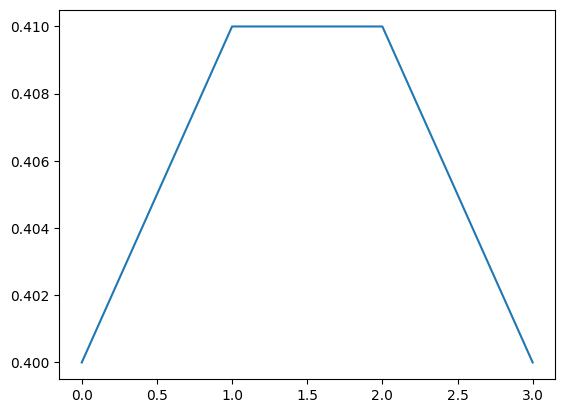

In [26]:
plt.plot(y_thin)

## Intra cluster

In [27]:
lat_thin = [ dh for dh in dh_latency if dh.entity == 'cluster' ]

size = 1024*1024

y_thin = [ dh.time(size) for dh in lat_thin ]

y_thin = np.array([ y for y in y_thin if y.size>0]).flatten()

In [28]:
print(f"Mean: {np.mean(y_thin):.4f}")
print(f"Std: {np.std(y_thin):.4f}")
print(f"Std/Mean: {np.std(y_thin)/np.mean(y_thin):.4f}")

Mean: 94.2250
Std: 0.3829
Std/Mean: 0.0041


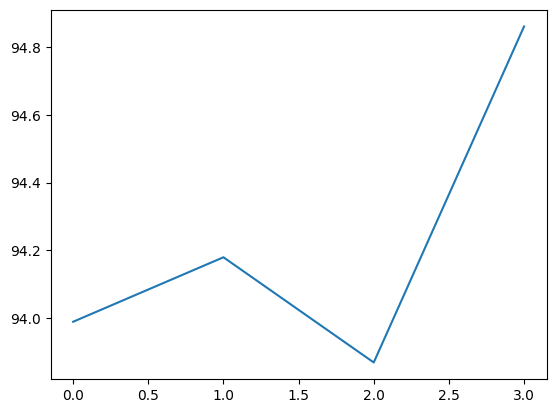

In [29]:
plt.plot(y_thin)

## Comparison

In [34]:
lat_socket = [ dh for dh in dh_latency if dh.entity == 'socket' ]
lat_node = [ dh for dh in dh_latency if dh.entity == 'node' ]
lat_cluster = [ dh for dh in dh_latency if dh.entity == 'cluster' ]

y_socket_8 = np.array([ dh.time(8) for dh in lat_socket[1:] ])
y_node_8 = np.array([ dh.time(8) for dh in lat_node ])
y_cluster_8 = np.array([ dh.time(8) for dh in lat_cluster ])

In [ ]:
print(f"Socket 8: {np.log10(np.mean(y_socket_8)):.4f} +- {np.log10(np.std(y_socket_8)):.4f}")
print(f"Node 8: {np.log10(np.mean(y_node_8)):.4f} +- {np.log10(np.std(y_node_8)):.4f}")
print(f"Cluster 8: {np.log10(np.mean(y_cluster_8)):.4f} +- {np.log10(np.std(y_cluster_8)):.4f}")

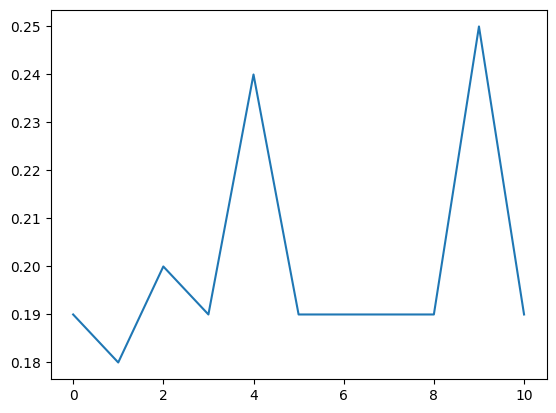

In [35]:
plt.plot(y_socket_8)

## Broadcast

Plot in 3D with the following data:
- **x**: number of processes
- **y**: size of the message
- **z**: time taken to broadcast the message

We will do three plots one for each implementation of the broadcast algorithm:
1. Basic linear
2. Chain
3. Binary tree

In [7]:
dh_bcast_socket = [ dh for dh in dh_bcast if dh.entity == 'core' ]
dh_bcast_node = [ dh for dh in dh_bcast if dh.entity == 'socket' ]
dh_bcast_cluster = [ dh for dh in dh_bcast if dh.entity == 'node' ]

In [10]:
dh_bcast_node

### Intra socket

In [ ]:
dh_bcast_temp = dh_bcast_socket
algorithm = 5
_x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
_y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
x, y = np.meshgrid(_x, _y)

def fn(n_proc, size):
    # Find the latency value for the given number of processes and message size
    dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
    return dh.data.loc[size]['Avg Latency (us)']
fn = np.vectorize(fn)

z = fn(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Message size')
ax.set_zlabel('Latency (us)')

# Save to pdf 
filename = f'bcast_socket_alg{algorithm}.pdf'
plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

In [ ]:
algorithms = [1,2,5]

dh_bcast_temp = dh_bcast_socket
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_socket_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    

dh_bcast_temp = dh_bcast_node
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_node_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
    
dh_bcast_temp = dh_bcast_cluster
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_bcast_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_bcast_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_bcast_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'bcast_cluster_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

#### Algorithm comparison

We know fix the message size to 2 bytes and compare the three algorithms.

In [13]:
def simple_moving_average(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    sma = np.convolve(data, weights, 'valid')
    return sma

In [14]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_socket if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_socket if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[window_size-1:], bcast_lat_alg1, label='Linear')
ax.plot(x[window_size-1:], bcast_lat_alg2, label='Binary Tree')
ax.plot(x[window_size-1:], bcast_lat_alg5, label='Binomial Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-socket')
ax.legend()
plt.show()

ValueError: v cannot be empty

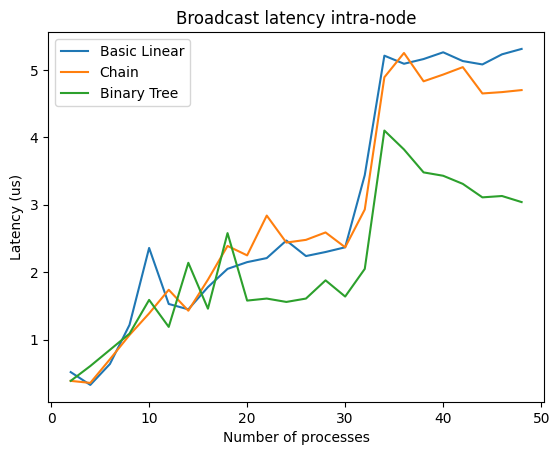

In [15]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_node if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_node if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[(window_size-1):], bcast_lat_alg1, label='Basic Linear')
ax.plot(x[(window_size-1):], bcast_lat_alg2, label='Chain')
ax.plot(x[(window_size-1):], bcast_lat_alg5, label='Binary Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-node')
ax.legend()
plt.show()

In [16]:
# dh_bcast_socket
size = 2
bcast_lat_alg1 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 1 ]).flatten()
bcast_lat_alg2 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 2 ]).flatten()
bcast_lat_alg5 = np.array([ dh.time(size) for dh in dh_bcast_cluster if dh.algorithm == 5 ]).flatten()

# Simple Moving Average
window_size = 1
bcast_lat_alg1 = simple_moving_average(bcast_lat_alg1, window_size)
bcast_lat_alg2 = simple_moving_average(bcast_lat_alg2, window_size)
bcast_lat_alg5 = simple_moving_average(bcast_lat_alg5, window_size)

x = np.array([ dh.n_proc for dh in dh_bcast_cluster if dh.algorithm == 1 ]).flatten()

# Compare with a plot
fig, ax = plt.subplots()
ax.plot(x[(window_size-1):], bcast_lat_alg1, label='Basic Linear')
ax.plot(x[(window_size-1):], bcast_lat_alg2, label='Chain')
ax.plot(x[(window_size-1):], bcast_lat_alg5, label='Binary Tree')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Latency (us)')
ax.set_title('Broadcast latency intra-cluster')
ax.legend()
plt.show()

ValueError: v cannot be empty

## Scatter

Plot in 3D with the following data:
- **x**: number of processes
- **y**: size of the message
- **z**: time taken to broadcast the message

We will do three plots one for each implementation of the broadcast algorithm:
1. Basic linear
2. Binomial

In [ ]:
dh_scat_socket = [ dh for dh in dh_scat if dh.entity == 'core' ]
dh_scat_node = [ dh for dh in dh_scat if dh.entity == 'socket' ]
dh_scat_cluster = [ dh for dh in dh_scat if dh.entity == 'node' ]

In [ ]:
dh_scat_temp = dh_scat_socket
algorithm = 1
_x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
_y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
x, y = np.meshgrid(_x, _y)

def fn(n_proc, size):
    # Find the latency value for the given number of processes and message size
    dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
    return dh.data.loc[size]['Avg Latency (us)']
fn = np.vectorize(fn)

z = fn(x, y)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

ax.plot_surface(x, y, z, cmap='viridis')
ax.set_xlabel('Number of processes')
ax.set_ylabel('Message size')
ax.set_zlabel('Latency (us)')

# Save to pdf 
filename = f'scat_cluster_alg{algorithm}.pdf'
plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')

In [ ]:
dh_scat_temp = dh_scat_socket
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_socket_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
dh_scat_temp = dh_scat_node
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_node_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')
    
dh_scat_temp = dh_scat_cluster
algorithms = [1,2]
for algorithm in algorithms:
    _x = np.array([ dh.n_proc for dh in dh_scat_temp if dh.algorithm == algorithm ]).flatten()
    _y = np.array([ dh.data.index for dh in dh_scat_temp if dh.algorithm == algorithm ][0]).flatten()
    x, y = np.meshgrid(_x, _y)

    def fn(n_proc, size):
        # Find the latency value for the given number of processes and message size
        dh = [ dh for dh in dh_scat_temp if dh.algorithm == algorithm and dh.n_proc == n_proc ][0]
        return dh.data.loc[size]['Avg Latency (us)']
    fn = np.vectorize(fn)

    z = fn(x, y)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=30, azim=-120)  # Change the elevation (vertical rotation) and azimuth (horizontal rotation)

    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('Number of processes')
    ax.set_ylabel('Message size')
    ax.set_zlabel('Latency (us)')

    # Save to pdf 
    filename = f'scat_cluster_alg{algorithm}.pdf'
    plt.savefig(f'/home/gabrielepintus/Documenti/Progetti/HPCProject/Exercise 1/Report/figures/{filename}')